## Теоретическая часть

1. Вспомним прошлый вебинар, мы рассматривали User-User рекомендации и Item-Item рекомендации. Чем они отличаются и чем они похожи? Если есть функция item_item_rec(interaction_matrix). Можно ли использовать эту функцию для user_user_rec?  
В чем принципиальные отличия item-item рекомендаций от ALS?


**User-user и item-item используют один и тот же принцип - на пересечении должны быть совпавшие пользователи или товары. Собственно в этом же и заключается различие - user-user ищем похожих пользователей, item-item - ищем похожие товары.  
Функцию item_item_rec(interaction_matrix) можно использовать для user_user_rec, принцип не менятеся - меняется только входные данные.  
Принципиальное различие от ALS: в ALS для вычислений используются матрицы меньшей размерности. Item-item - explicit, а ALS - implicit**

2. Приведите 3 примера весов (те, которых не было на вебинаре: сумма покупок, количество покупок - неинтересно) user-item матрицы для задачи рекомендаций товаров 


**Добавление товара в "избранное", добавление товара в корзину, время проведенное на странице товара**

3. Какие ограничения есть у ALS? (Тип информации, линейность/нелинейность факторов и т д)


**Наверное, бессмыслено использовать ALS, когда нет возможности явно определить вес или его вариация ограничена.**

4. Мы рассматривали bm_25_weight. 
Опишите, как он работает. Как сделать рекомендации только на основе bm_25? (Можно и нужно пользоваться любыми источниками, приложите на них ссылки). Какие еще способы перевзвешивания user-item матрицы Вы знаете / можете предложить (ещё 2-3 способа)?

**Вводится зависимость релевантности от вхождения или не вхождения слов в запросах с более чем одного слова. Релевантность всего поискового запроса равна сумме релевантностей всех слов.  
Если слово отсутствует, значит его частота равна 0, соответственно релевантность 0. При использовании в запросе 2х и более слов, одно из которых одно из которых встречается реже, выбор будет в пользву документа который содержат это слово.**

## Практическая часть


In [ ]:
import implicit

In [ ]:
# import data
# utils functions like in webinar

### Подбор матрицы $c_{ui}$
Попробуйте различные варианты матрицы весов (3+ вариантов). Обучите алгоритм для различных $C$. В качестве результата приведите таблицу: матрица весов - результат на train и validation.
Сделате качественные выводы.


### Оптимизация гипперпараметров
Для лучшей матрицы весов из первого задания подберите оптимальные $\lambda$ и n_factors. Подбор можно делать вручную (цикл в цикле, аналог sklearn.GridSearch, или случайно - sklearn.GridSearch). Или Вы можете воспользоваться библиотеками для автоматического подбора гипперпараметров (любые на Ваш вкус). В качестве результата постройте графики:
1. Значение параметра - время обучения 
2. Значение параметра - качество train, качество validation  

Сделайте качественные выводы

**P.S.** Не пишите отписки в качестве выводов. Мне интресены Ваши рассуждения, трудности, с которыми Вы сталкнулись и что-то, что Вас удивило. Если выводы контринтуитивны - напишите об этом, в этом нет ничего страшного!

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import implicit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Функции из 1-ого вебинара
import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
#from implicit.evaluation import precision_at_k

In [ ]:
def precision_at_k(recommended_list, bought_list, k=8):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    precision = flags.sum() / len(recommended_list)
    
    
    return precision

In [ ]:
data = pd.read_csv('C:\\Users\\Mell\\Desktop\\Рекомендательные системы\\webinar_3\\retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

In [ ]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

In [ ]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [ ]:
# Заведем фиктивный item_id (если юзер не покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

In [ ]:
user_item_matrix.shape

In [ ]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [ ]:
%%time

model = AlternatingLeastSquares(factors=100, #k
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)

In [ ]:
[id_to_itemid[rec[0]] for rec in recs]

In [ ]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)]
    return res

In [ ]:
%%time
    
result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

In [ ]:
result_train = data_train.groupby('user_id')['item_id'].unique().reset_index()
result_train.columns=['user_id', 'actual']
result_train.head(2)

In [ ]:
result_train['als'] = result_train['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

### Подбор матрицы $c_{ui}$

In [ ]:
#Исходные результаты
res_dict = {'Data train': result_train.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean(),
                   'Data test': result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()}
res_s = pd.Series(res_dict)
res_df = pd.DataFrame({'ALS - quantity': res_s})
res_df

In [ ]:
import time

In [ ]:
def c_matrix(param, data, factors = 100, regularization = 0.001):
    user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values=param, # Можно пробовать другие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

    user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

    # переведем в формат saprse matrix
    sparse_user_item = csr_matrix(user_item_matrix).tocsr()
    userids = user_item_matrix.index.values
    itemids = user_item_matrix.columns.values

    matrix_userids = np.arange(len(userids))
    matrix_itemids = np.arange(len(itemids))

    id_to_itemid = dict(zip(matrix_itemids, itemids))
    id_to_userid = dict(zip(matrix_userids, userids))

    itemid_to_id = dict(zip(itemids, matrix_itemids))
    userid_to_id = dict(zip(userids, matrix_userids))
    
    model = AlternatingLeastSquares(factors=factors, 
                                regularization=regularization,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)
    startTime = time.time()
    
    model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)
    
    endTime = time.time()
    totalTime = endTime - startTime

    recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)
    
    if data == 'train':
        result_train['ALS -'+ param] = result_train['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
        return [result_train.apply(lambda row: precision_at_k(row['ALS -'+param], row['actual']), axis=1).mean(), totalTime]
    if data == 'test':
        result['ALS -'+ param] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
        return [result.apply(lambda row: precision_at_k(row['ALS -'+ param], row['actual']), axis=1).mean(), totalTime]

In [ ]:
param = ['sales_value', 'retail_disc', 'trans_time', 'store_id']
datas = ['train', 'test']
for i in param:
    c_list = []
    for data in datas:
        c_list.append(c_matrix(i, data)[0])
    res_df['ALS - ' + i] = c_list

In [ ]:
res_df

**Изменение признака в качестве параметра матрицы весов не дало значимых изменений метрики.**

### Оптимизация гипперпараметров###

Возьмем исходное значение признака - quantity

In [ ]:
factors = [50, 100, 300]
regularizations = [0.0005, 0.001, 0.005]

In [ ]:
train_df = pd.DataFrame(index=regularizations)

In [ ]:
for i in factors:
    precision_list = []
    for j in regularizations:
        precision_list.append(c_matrix(param = 'quantity', data = 'train', factors = i, regularization = j)[0])
    train_df[i] = precision_list

In [ ]:
test_df = pd.DataFrame(index=regularizations)
time_df = pd.DataFrame(index=regularizations)
for i in factors:
    precision_list = []
    time_list = []
    for j in regularizations:
        val = c_matrix(param = 'quantity', data = 'test', factors = i, regularization = j)
        precision_list.append(val[0])
        time_list.append(val[1])
    test_df[i] = precision_list
    time_df[i] = time_list

Text(51.0, 0.5, 'regularizations')

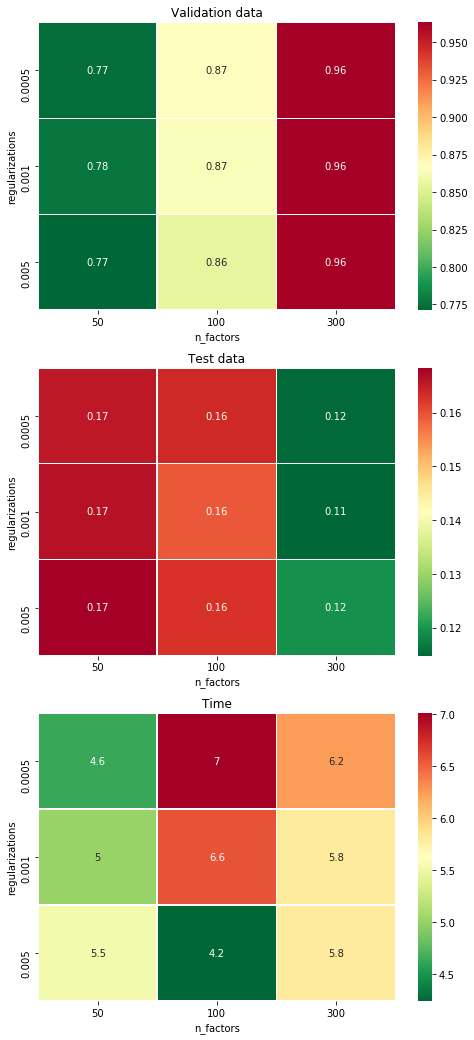

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize = (8,18))

sns.heatmap(train_df, cmap='RdYlGn_r', linewidths=0.5, annot=True, ax = axes[0])
sns.heatmap(test_df, cmap='RdYlGn_r', linewidths=0.5, annot=True, ax = axes[1])
sns.heatmap(time_df, cmap='RdYlGn_r', linewidths=0.5, annot=True, ax = axes[2])

axes[0].set(title = 'Validation data')
axes[1].set(title = 'Test data')
axes[2].set(title = 'Time')

axes[0].set_xlabel('n_factors')
axes[0].set_ylabel('regularizations')
axes[1].set_xlabel('n_factors')
axes[1].set_ylabel('regularizations')
axes[2].set_xlabel('n_factors')
axes[2].set_ylabel('regularizations')

**Выводы следующие: увеличение параметра n_factors увеличивает время обучения, дает хорошую прибавку в точности предсказаний на валидационных данных, но ухудшает результаты предсказаний на тестовых данных (переобучение?).  
Изменение параметра регуляризации также влияет на время обучения, при этом при правильном подборе также может дать небольшуую прибавку в точности предсказаний.**